# Importing Libraries

In [44]:
import pandas as pd
import numpy as np

# Building Decision Tree Model From Scratch

In [45]:
from collections import Counter


def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
     
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        
        parent_entropy = entropy(y)

     
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    

# Loading Dataset

In [46]:
df=pd.DataFrame(pd.read_excel("Social_Network_Ads.xlsx"))
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


# Data Cleaning

In [47]:
df.isnull().sum()

User ID             0
Gender              0
Age                 0
EstimatedSalary     0
Purchased           0
dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
User ID             400 non-null int64
Gender              400 non-null object
Age                 400 non-null int64
EstimatedSalary     400 non-null int64
Purchased           400 non-null int64
dtypes: int64(4), object(1)
memory usage: 15.7+ KB


In [49]:
X = df.iloc[:,[2,3]].values
y = df.iloc[:,4].values

# Splitting the Dataset

In [50]:
from sklearn.model_selection import train_test_split   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Scaling the Data

In [51]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [52]:
classifier = DecisionTree(max_depth=10)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

# Model Evaluation

In [53]:
def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
acc = accuracy(y_test, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.910


# Visualising

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


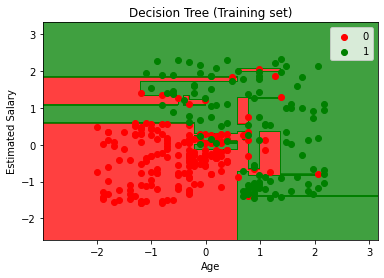

In [54]:
from matplotlib.colors import ListedColormap
X_set,y_set=X_train,y_train
X1,X2=np.meshgrid(np.arange(start=X_set[:,0].min()-1,stop=X_set[:,0].max()+1,step=0.01),
                 np.arange(start=X_set[:,1].min()-1,stop=X_set[:,1].max()+1,step=0.01))
plt.contourf(X1,X2,classifier.predict(np.array([X1.ravel(),X2.ravel()]).T).reshape(X1.shape),
            alpha=0.75,cmap=ListedColormap(('red','green')))
plt.xlim(X1.min(),X1.max())
plt.ylim(X2.min(),X2.max())
for i,j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set==j,0],X_set[y_set==j,1],
               c=ListedColormap(('red','green'))(i),label=j)
plt.title('Decision Tree (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()